In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

pd.set_option('display.max_columns', None)

In [2]:
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.stattools import adfuller

from sklearn.model_selection import TimeSeriesSplit
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.statespace.sarimax import SARIMAX
import pmdarima as pm
from sklearn.metrics import mean_squared_error as mse, mean_absolute_error as mae, mean_absolute_percentage_error as mape
import time

import warnings

from statsmodels.tools.sm_exceptions import ValueWarning
warnings.filterwarnings("ignore", category=ValueWarning)

from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)

warnings.filterwarnings("ignore", category=UserWarning)

In [3]:
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb

# Loading Datasets

In [4]:
df_ts_final = pd.read_csv('./data_artifacts/df_ts_final.csv')
df_ts_final.shape

(37422, 13)

In [5]:
with open('./data_artifacts/ts_dict.pkl', 'rb') as f:
    ts_dict = pickle.load(f)

# Time based Train-Test Split

## Time Series

In [6]:
ts_dict = {}

for ps in df_ts_final['ps_idx'].unique():
    
    # Filter data by park space
    df_ps = df_ts_final.loc[df_ts_final['ps_idx']==ps].copy()
    df_ps.set_index('TimeStamp', inplace=True)
    
    # Sort by Timestamp
    df_ps = df_ps.sort_index()
    
    # Append the series in dictionary
    ts_dict[df_ps['ps_idx'].iloc[0]] = df_ps['Occupancy_Rate']
    
len(ts_dict.keys())

27

In [7]:
def train_test_splitter_time_series(ts_dict_raw, n_test_points):
    
    ts_train_test_dict = {}
    
    for ps_idx in ts_dict_raw.keys():
        ser_ts_ps = ts_dict_raw[ps_idx]
        
        ts_train_test_dict[ps_idx] = {}
        ts_train_test_dict[ps_idx]['train'] = ser_ts_ps[:-n_test_points]
        ts_train_test_dict[ps_idx]['test'] = ser_ts_ps[-n_test_points:]
        
        
    return ts_train_test_dict
        

predict_weeks = 1
predict_points = predict_weeks*7*18
ts_train_test_splitted_dict = train_test_splitter_time_series(ts_dict_raw=ts_dict, n_test_points=predict_points)

In [8]:
# 1st Parking Lot: Train Set
print('DF Shape:', ts_train_test_splitted_dict[1]['train'].shape)
print('-'*50)
ts_train_test_splitted_dict[1]['train'].head(3)

DF Shape: (1260,)
--------------------------------------------------


TimeStamp
2016-10-04 08:00:00    10.5719
2016-10-04 08:30:00    11.0919
2016-10-04 09:00:00    13.8648
Name: Occupancy_Rate, dtype: float64

In [9]:
# 1st Parking Lot: Test Set
print('DF Shape:', ts_train_test_splitted_dict[1]['test'].shape)
print('-'*50)
ts_train_test_splitted_dict[1]['test'].head(3)

DF Shape: (126,)
--------------------------------------------------


TimeStamp
2016-12-13 08:00:00    2.4263
2016-12-13 08:30:00    3.4662
2016-12-13 09:00:00    5.7192
Name: Occupancy_Rate, dtype: float64

### Saving TimeSeries

In [10]:
# # Saving the final series/dataframe in a dictionary having park_space_id as key (saving as pickle file)
# with open('./data_artifacts/ts_dict.pkl', 'wb') as f:
#     pickle.dump(ts_dict, f)

In [11]:
# # Saving the final train-test timeseries in a dictionary having park_space_id as key (saving as pickle file)
# with open('./data_artifacts/ts_train_test_dict.pkl', 'wb') as f:
#     pickle.dump(ts_train_test_splitted_dict, f)

## DataFrames

In [12]:
def train_test_splitter_regression(df_raw, n_test_points):
    
    reg_train_test_dict = {}
    
    for ps_idx in df_raw['ps_idx'].unique()[:]:
        df_raw_ps = df_raw.loc[df_raw['ps_idx']==ps_idx].copy()
        
        
        df_raw_ps['Year'] = pd.to_datetime(df_raw_ps['Date']).dt.year
        df_raw_ps['Month'] = pd.to_datetime(df_raw_ps['Date']).dt.month
        df_raw_ps['Day'] = pd.to_datetime(df_raw_ps['Date']).dt.day
        
        df_raw_ps_final = df_raw_ps[['TimeStamp', 'Year', 'Month', 'Day',   
                                     'DayOfWeek', 'isWeekend', 'Hour', 'Minute',    
                                     'Capacity', 'Occupancy_Rate']].copy()
        
        df_raw_ps_final['TimeStamp'] = pd.to_datetime(df_raw_ps_final['TimeStamp'])
        df_raw_ps_final.set_index('TimeStamp', inplace=True)

        reg_train_test_dict[ps_idx] = {}
        reg_train_test_dict[ps_idx]['train'] = df_raw_ps_final.iloc[:-n_test_points]
        reg_train_test_dict[ps_idx]['test'] = df_raw_ps_final.iloc[-n_test_points:]
        
        
    return reg_train_test_dict
        

predict_weeks = 1
predict_points = predict_weeks*7*18
reg_train_test_splitted_dict = train_test_splitter_regression(df_raw=df_ts_final, n_test_points=predict_points)

In [13]:
# 1st Parking Lot: Train Set
print('DF Shape:', reg_train_test_splitted_dict[1]['train'].shape)
print('-'*50)
reg_train_test_splitted_dict[1]['train'].head(3)

DF Shape: (1260, 9)
--------------------------------------------------


,Year,Month,Day,DayOfWeek,isWeekend,Hour,Minute,Capacity,Occupancy_Rate
TimeStamp,,,,,,,,,
2016-10-04 08:00:00,2016,10,4,1,False,8,0,577.0,10.5719
2016-10-04 08:30:00,2016,10,4,1,False,8,30,577.0,11.0919
2016-10-04 09:00:00,2016,10,4,1,False,9,0,577.0,13.8648


In [14]:
# 1st Parking Lot: test Set
print('DF Shape:', reg_train_test_splitted_dict[1]['test'].shape)
print('-'*50)
reg_train_test_splitted_dict[1]['test'].head(3)

DF Shape: (126, 9)
--------------------------------------------------


,Year,Month,Day,DayOfWeek,isWeekend,Hour,Minute,Capacity,Occupancy_Rate
TimeStamp,,,,,,,,,
2016-12-13 08:00:00,2016,12,13,1,False,8,0,577.0,2.4263
2016-12-13 08:30:00,2016,12,13,1,False,8,30,577.0,3.4662
2016-12-13 09:00:00,2016,12,13,1,False,9,0,577.0,5.7192


# Model Training: Time Series

## Helper Functions

In [15]:
# Creating a function to print values of all metrics.
def ts_performance_metrics(actual, predicted):
    print('-'*50)
    print('Forecasting Metrics')
    print('-'*50)
    metric_mae = round(mae(actual, predicted), 3)
    metric_rmse = round(mse(actual, predicted)**0.5, 3)
    print('MAE :', metric_mae)
    print('RMSE :', metric_rmse) 
    # print('MAPE:', round(mape(actual, predicted), 3))
    
    return metric_mae, metric_rmse

# Model Training: Time Series: Exponential Smoothing

## Loading tuned hyperparameters

In [16]:
df_hyp_tuned_params_tes_models = pd.read_csv('./data_artifacts/df_hyp_tuned_params_tes_models.csv')
df_hyp_tuned_params_tes_models.head(2)

,ps_idx,alpha,beta,gamma,cv_rmse,cv_mae
0,1,0.75,0.0,0.15,8.224,6.038
1,2,0.15,0.0,0.00,11.542,8.014


In [17]:
df_hyp_tuned_params_tes_models.set_index('ps_idx').loc[1]

alpha      0.750
beta       0.000
gamma      0.150
cv_rmse    8.224
cv_mae     6.038
Name: 1, dtype: float64

## Training

In [18]:
def forecast_exp_smooth_all_park_lots(train_test_splitted_dict, hyp_tuned_tes_params):
    
    fitted_models_dict = {'ps_idx':[], 'tes_mae':[], 'tes_rmse':[], 'tes_fitted_model': []}

    for ps_idx in list(train_test_splitted_dict.keys())[:]:
        
        print(f'ParkLot: {ps_idx}')

        train_series = ts_train_test_splitted_dict[ps_idx]['train']
        test_series = ts_train_test_splitted_dict[ps_idx]['test']

        # Extracting the best parameters
        alpha = hyp_tuned_tes_params.loc[ps_idx]['alpha']
        beta = hyp_tuned_tes_params.loc[ps_idx]['beta']
        gamma = hyp_tuned_tes_params.loc[ps_idx]['gamma']
        
        # Fitting Model
        model = ExponentialSmoothing(train_series, trend='add', seasonal='add', 
                                     seasonal_periods=126).fit(smoothing_level=alpha,                                         
                                                               smoothing_trend=beta,             
                                                               smoothing_seasonal=gamma)


        # Forecast for the validation set
        forecast = model.forecast(steps=len(test_series))
        forecast.index = test_series.index
        # print(test_series.shape, forecast.shape, forecast.isna().sum())
        fr_mae, fr_rmse = ts_performance_metrics(actual=test_series, predicted=forecast)
        
        # Storing the fitted models
        fitted_models_dict['ps_idx'].append(ps_idx)
        fitted_models_dict['tes_mae'].append(fr_mae)
        fitted_models_dict['tes_rmse'].append(fr_rmse)
        fitted_models_dict['tes_fitted_model'].append(model)
        
        print('-'*50+f'Completed!'+'-'*50)
        
    return pd.DataFrame(fitted_models_dict)

df_fitted_exp_smt_models = forecast_exp_smooth_all_park_lots(train_test_splitted_dict=ts_train_test_splitted_dict, 
                                                            hyp_tuned_tes_params=df_hyp_tuned_params_tes_models.set_index('ps_idx'))
df_fitted_exp_smt_models.head()

ParkLot: 1
--------------------------------------------------
Forecasting Metrics
--------------------------------------------------
MAE : 4.67
RMSE : 7.75
--------------------------------------------------Completed!--------------------------------------------------
ParkLot: 2
--------------------------------------------------
Forecasting Metrics
--------------------------------------------------
MAE : 9.059
RMSE : 14.703
--------------------------------------------------Completed!--------------------------------------------------
ParkLot: 3
--------------------------------------------------
Forecasting Metrics
--------------------------------------------------
MAE : 4.455
RMSE : 5.991
--------------------------------------------------Completed!--------------------------------------------------
ParkLot: 4
--------------------------------------------------
Forecasting Metrics
--------------------------------------------------
MAE : 4.232
RMSE : 5.636
------------------------------------

,ps_idx,tes_mae,tes_rmse,tes_fitted_model
0,1,4.670,7.750,<statsmodels.tsa.holtwinters.results.HoltWinte...
1,2,9.059,14.703,<statsmodels.tsa.holtwinters.results.HoltWinte...
2,3,4.455,5.991,<statsmodels.tsa.holtwinters.results.HoltWinte...
3,4,4.232,5.636,<statsmodels.tsa.holtwinters.results.HoltWinte...
4,5,10.160,11.500,<statsmodels.tsa.holtwinters.results.HoltWinte...


## Saving Fitted Models as Pickle Files

In [19]:
df_fitted_exp_smt_models.tes_rmse.describe()

count    27.000000
mean      7.200333
std       3.433883
min       1.808000
25%       5.272500
50%       6.236000
75%       8.469500
max      15.636000
Name: tes_rmse, dtype: float64

In [20]:
fit_models_tes_dict = dict(zip(df_fitted_exp_smt_models['ps_idx'], df_fitted_exp_smt_models['tes_fitted_model']))

# # Saving the fitted models in a dict
# with open('./data_artifacts/fit_models_tes_dict.pkl', 'wb') as f:
#     pickle.dump(fit_models_tes_dict, f)

# Model Training: Time Series: SARIMA

In [21]:
# def forecast_sarima_all_park_lots(train_test_splitted_dict):
    
#     fitted_models_dict = {'ps_idx':[], 'sarima_mae':[], 'sarima_rmse':[], 'sarima_fitted_model': []}

#     for ps_idx in list(train_test_splitted_dict.keys())[5:10]:
        
#         print(f'ParkLot: {ps_idx}')

#         train_series = ts_train_test_splitted_dict[ps_idx]['train']
#         test_series = ts_train_test_splitted_dict[ps_idx]['test']

#         p, d, q = 1, 0, 1
#         P, D, Q, s = 0, 1, 0, 126

#         model = SARIMAX(train_series,                                
#                         order=(p,d,q),                               
#                         seasonal_order=(P, D, Q, s),                               
#                         initialization='approximate_diffuse')

#         # Fitting Model
#         model_fit = model.fit(disp=False)


#         # Forecast for the validation set
#         forecast = model_fit.forecast(steps=len(test_series), dynamic = True)
#         forecast.index = test_series.index
#         # print(test_series.shape, forecast.shape, forecast.isna().sum())
#         fr_mae, fr_rmse = ts_performance_metrics(actual=test_series, predicted=forecast)
        
#         # Storing the fitted models
#         fitted_models_dict['ps_idx'].append(ps_idx)
#         fitted_models_dict['sarima_mae'].append(fr_mae)
#         fitted_models_dict['sarima_rmse'].append(fr_rmse)
#         fitted_models_dict['sarima_fitted_model'].append(model_fit)
        
#         print('-'*50+f'Completed!'+'-'*50)
        
#     return fitted_models_dict

# fitted_sarima_models_df = pd.DataFrame(forecast_sarima_all_park_lots(train_test_splitted_dict=ts_train_test_splitted_dict))

# Model Training: Regression: Data Preperation

## Adding TES Model Output as a feature to Train/Test DF

In [22]:
# Saving the fitted tes models in a dict
tes_fit_models_dict = dict(zip(df_fitted_exp_smt_models['ps_idx'], df_fitted_exp_smt_models['tes_fitted_model']))
# tes_fit_models_dict

In [23]:
def add_tes_model_output_to_reg_df(v1_reg_train_test_splitted_dict, fitted_tes_models_dict):

    v2_reg_train_test_splitted_dict = {}

    for ps_idx in list(v1_reg_train_test_splitted_dict.keys())[:]:

        # Loading TES Model
        tes_model = fitted_tes_models_dict[ps_idx]

        # TES Prediction & Forecast
        tes_model_prediction = tes_model.fittedvalues
        tes_model_prediction.index = v1_reg_train_test_splitted_dict[ps_idx]['train'].index
        tes_model_prediction.name='tes_op'
        # print(tes_model_prediction)

        # TES Forecast
        forecast_steps = v1_reg_train_test_splitted_dict[ps_idx]['test'].shape[0]
        tes_model_forecast = tes_model.forecast(steps=forecast_steps)
        tes_model_forecast.index = v1_reg_train_test_splitted_dict[ps_idx]['test'].index
        tes_model_forecast.name='tes_op'
        # print(tes_model_forecast)
        
        
        # Merge TES Output with Train & Test df
        df_train = v1_reg_train_test_splitted_dict[ps_idx]['train']
        df_test = v1_reg_train_test_splitted_dict[ps_idx]['test']
        # print(df_train)

        df_train_v2 = pd.merge(df_train, tes_model_prediction, left_index=True, right_index=True)
        df_test_v2 = pd.merge(df_test, tes_model_forecast, left_index=True, right_index=True)
        # print(f'ParkSpace-{ps_idx}: Shape-Train: {df_train_v2.shape}, Shape_Test: {df_test_v2.shape}')
        
        # Save data in a dictionary
        v2_reg_train_test_splitted_dict[ps_idx] = {}
        v2_reg_train_test_splitted_dict[ps_idx]['train'] = df_train_v2
        v2_reg_train_test_splitted_dict[ps_idx]['test'] = df_test_v2


    return v2_reg_train_test_splitted_dict
    
    
reg_v2_train_test_splitted_dict = add_tes_model_output_to_reg_df(v1_reg_train_test_splitted_dict=reg_train_test_splitted_dict, 
                                                                 fitted_tes_models_dict=tes_fit_models_dict)

## Helper Functions (V1):

In [62]:
# Feature Engineering
def features_lagged(df_inp):
    
    df = df_inp.copy()
    

    # Lagged Features
    df['lag_1'] = df['Occupancy_Rate'].shift(1)
    df['lag_2'] = df['Occupancy_Rate'].shift(2)
    df['lag_3'] = df['Occupancy_Rate'].shift(3)

    df['lag_18'] = df['Occupancy_Rate'].shift(18)
    df['lag_19'] = df['Occupancy_Rate'].shift(19)
    df['lag_20'] = df['Occupancy_Rate'].shift(20)
    
    
    # Encoding Week-Weekend as numeric
    df['isWeekend'] = df['isWeekend'].astype('int')
    
    
    # Impute Missing data with mean imputation
    target_mean = df.Occupancy_Rate.mean()

    df.lag_1.fillna(target_mean, inplace=True)
    df.lag_2.fillna(target_mean, inplace=True)
    df.lag_3.fillna(target_mean, inplace=True)

    df.lag_18.fillna(target_mean, inplace=True)
    df.lag_19.fillna(target_mean, inplace=True)
    df.lag_20.fillna(target_mean, inplace=True)
    
    
    # # Setting timestamp as index: Not required (Doing it earlier)
    # df.set_index('TimeStamp', inplace=True)
    
    return df



# Feature Scaling
def feat_scaler(X_train_inp, X_test_inp):
    
    std_scaler = StandardScaler()
    X_train_inp_scl = std_scaler.fit_transform(X_train_inp)
    X_test_inp_scl = std_scaler.transform(X_test_inp)
    
    return X_train_inp_scl, X_test_inp_scl, std_scaler


# X-y splitter
def preprocess_pipe(df_train, df_test):
    
    X_train = df_train.drop(['Occupancy_Rate'], axis=1)
    y_train = df_train['Occupancy_Rate']

    X_test = df_test.drop(['Occupancy_Rate'], axis=1)
    y_test = df_test['Occupancy_Rate']
    
    X_train_scl, X_test_scl, fitted_std_scaler = feat_scaler(X_train_inp=X_train, X_test_inp=X_test)
    
    return X_train, X_test, X_train_scl, X_test_scl, y_train, y_test, fitted_std_scaler


# Generate Regression Report
def get_regression_report(model, df_train, X_train, y_train, X_test, y_test):
    
    sep_length = 50
    
    print('REGRESSION REPORT')
    print('-'*sep_length)
    
    # Fit regression model
    model.fit(X_train, y_train)
    
    y_train_pred = model.predict(X_train)
    # y_train_pred = pd.Series(y_train_pred)
    # y_train_pred.index = y_train.index
    
    y_test_pred = model.predict(X_test)
    # y_test_pred = pd.Series(y_test_pred)
    # y_test_pred.index = y_test.index
    
    # Model Evaluation metrics
    train_rmse = round(mse(y_train, y_train_pred)**0.5, 3)
    test_rmse = round(mse(y_test, y_test_pred)**0.5, 3)
    
    train_mae = round(mae(y_train, y_train_pred), 3)
    test_mae = round(mae(y_test, y_test_pred), 3)
    
    # Store Fitted Model & Metrics
    # metrics_arr = np.array([])
    metrics_arr = np.array([train_rmse, train_mae, test_rmse, test_mae])
    
    print('Training RMSE:', train_rmse)
    print('Testing RMSE:', test_rmse)
    print('-'*sep_length)
    
    # # Feature importances
    # ser_feat_imp = pd.Series(model.feature_importances_, index=df_train.columns).sort_values(ascending=False)
    # # Plot feature importances
    # plt.figure(figsize=(20, 4))
    # plt.bar(ser_feat_imp.index, ser_feat_imp.values)
    # plt.xticks(rotation=90)
    # plt.show()
    
    return metrics_arr


# Plot output post model training
def plot_test_set_org_predict(y_test, y_pred):
    
    y_pred_ser = pd.Series(y_pred)
    y_pred_ser.index = y_test.index
    
    plt.figure(figsize=(20, 4))
    y_test.plot(marker='o', label='TestSet-Original')
    y_pred_ser.plot(marker='o', label='TestSet-Predicted')
    plt.legend()
    plt.show()

## Helper Functions (V2):

In [63]:
# Train Regression Models: Random Forest
def train_reg_models_rf(reg_final_train_test_splitted_dict, hyp_tuned_reg_params):
    
    fitted_models_dict = {'ps_idx':[], 
                          'reg_train_rmse':[], 'reg_train_mae':[], 
                          'reg_test_rmse':[], 'reg_test_mae':[], 
                          'reg_fitted_model': [],
                          'fitted_scaler': []
                         }

    
    for ps_idx in list(reg_final_train_test_splitted_dict.keys())[:]:
        
        print(f'PARK SPACE: {ps_idx}')
        
        df_train_ps = reg_final_train_test_splitted_dict[ps_idx]['train']
        df_test_ps = reg_final_train_test_splitted_dict[ps_idx]['test']
        
        X_train, X_test, X_train_scl, X_test_scl, y_train, y_test, fitted_scaler = preprocess_pipe(df_train=df_train_ps, 
                                                                                                   df_test=df_test_ps)
        
        # Instantiating Model with best parameters
        rfr = RandomForestRegressor(random_state = 42, 
                                    criterion    = 'squared_error', 
                                    n_estimators = hyp_tuned_reg_params.loc[ps_idx]['n_estimators'], 
                                    max_features = hyp_tuned_reg_params.loc[ps_idx]['max_features'], 
                                    max_depth    = hyp_tuned_reg_params.loc[ps_idx]['max_depth'], 
                                    ccp_alpha    = hyp_tuned_reg_params.loc[ps_idx]['ccp_alpha'])
        
        
        iter_metrics_arr = get_regression_report(model=rfr, df_train=X_train, 
                                                 X_train=X_train_scl, y_train=y_train, 
                                                 X_test=X_test_scl, y_test=y_test)
        
        
        # Fitting model so that it can be saved
        rfr.fit(X_train_scl, y_train)
        
        
        # Appenind metrics and fitted models to a dict
        fitted_models_dict['ps_idx'].append(ps_idx)
        fitted_models_dict['reg_train_rmse'].append(iter_metrics_arr[0])
        fitted_models_dict['reg_train_mae'].append(iter_metrics_arr[1])
        fitted_models_dict['reg_test_rmse'].append(iter_metrics_arr[2])
        fitted_models_dict['reg_test_mae'].append(iter_metrics_arr[3])
        fitted_models_dict['reg_fitted_model'].append(rfr)
        fitted_models_dict['fitted_scaler'].append(fitted_scaler)
        
        
    return pd.DataFrame(fitted_models_dict)



# Train Regression Models: XGBoost
def train_reg_models_xgb(reg_final_train_test_splitted_dict, hyp_tuned_reg_params):
    
    fitted_models_dict = {'ps_idx':[], 
                          'reg_train_rmse':[], 'reg_train_mae':[], 
                          'reg_test_rmse':[], 'reg_test_mae':[], 
                          'reg_fitted_model': [],
                          'fitted_scaler': []
                         }

    
    for ps_idx in list(reg_final_train_test_splitted_dict.keys())[:]:
        
        print(f'PARK SPACE: {ps_idx}')
        
        df_train_ps = reg_final_train_test_splitted_dict[ps_idx]['train']
        df_test_ps = reg_final_train_test_splitted_dict[ps_idx]['test']
        
        X_train, X_test, X_train_scl, X_test_scl, y_train, y_test, fitted_scaler = preprocess_pipe(df_train=df_train_ps, 
                                                                                                   df_test=df_test_ps)
        
        
        # Instantiating Model with best parameters
        xgbr = xgb.XGBRegressor(n_estimators     = int(hyp_tuned_reg_params.loc[ps_idx]['n_estimators']), 
                                learning_rate    = hyp_tuned_reg_params.loc[ps_idx]['learning_rate'], 
                                gamma            = hyp_tuned_reg_params.loc[ps_idx]['gamma'], 
                                max_depth        = int(hyp_tuned_reg_params.loc[ps_idx]['max_depth']), 
                                subsample        = hyp_tuned_reg_params.loc[ps_idx]['subsample'], 
                                colsample_bytree = hyp_tuned_reg_params.loc[ps_idx]['colsample_bytree'], 
                                # random_state     = 42
                               )

        iter_metrics_arr = get_regression_report(model=xgbr, df_train=X_train, 
                                                 X_train=X_train_scl, y_train=y_train, 
                                                 X_test=X_test_scl, y_test=y_test)
        
        
        # Fitting model so that it can be saved
        xgbr.fit(X_train_scl, y_train)
        
        
        # Appenind metrics and fitted models to a dict
        fitted_models_dict['ps_idx'].append(ps_idx)
        fitted_models_dict['reg_train_rmse'].append(iter_metrics_arr[0])
        fitted_models_dict['reg_train_mae'].append(iter_metrics_arr[1])
        fitted_models_dict['reg_test_rmse'].append(iter_metrics_arr[2])
        fitted_models_dict['reg_test_mae'].append(iter_metrics_arr[3])
        fitted_models_dict['reg_fitted_model'].append(xgbr)
        fitted_models_dict['fitted_scaler'].append(fitted_scaler)
        
        
    return pd.DataFrame(fitted_models_dict)

## Feature Engineering: Adding Lagged Features

In [26]:
def perform_feat_eng(df_dict):
    
    reg_final_train_test_splitted_dict = {}
    
    for ps_idx in list(df_dict.keys()):
        
        df_train = df_dict[ps_idx]['train']
        df_test = df_dict[ps_idx]['test']
        
        df_train_final = features_lagged(df_inp=df_train)
        df_test_final = features_lagged(df_inp=df_test)
        
        reg_final_train_test_splitted_dict[ps_idx] = {}
        reg_final_train_test_splitted_dict[ps_idx]['train'] = df_train_final
        reg_final_train_test_splitted_dict[ps_idx]['test'] = df_test_final
        
        
    
    return reg_final_train_test_splitted_dict



reg_final_v1_train_test_splitted_dict = perform_feat_eng(df_dict=reg_train_test_splitted_dict)
reg_final_v2_train_test_splitted_dict = perform_feat_eng(df_dict=reg_v2_train_test_splitted_dict)

In [27]:
print(reg_final_v1_train_test_splitted_dict[1]['train'].shape)
print(reg_final_v1_train_test_splitted_dict[1]['test'].shape)
print(reg_final_v2_train_test_splitted_dict[1]['train'].shape)
print(reg_final_v2_train_test_splitted_dict[1]['test'].shape)

(1260, 15)
(126, 15)
(1260, 16)
(126, 16)


In [28]:
# Dropping 'Capacity' columns
def drop_cols(reg_train_test_dict, col):

    reg_mod_train_test_dict = {}
    for ps_idx in list(reg_train_test_dict.keys())[:]:

        df_train = reg_train_test_dict[ps_idx]['train']
        df_test = reg_train_test_dict[ps_idx]['test']

        reg_mod_train_test_dict[ps_idx] = {}
        reg_mod_train_test_dict[ps_idx]['train'] = df_train.drop([col], axis=1)
        reg_mod_train_test_dict[ps_idx]['test'] = df_test.drop([col], axis=1)
        
    return reg_mod_train_test_dict
    

reg_final_v1_mod_train_test_splitted_dict = drop_cols(reg_train_test_dict=reg_final_v1_train_test_splitted_dict, col='Capacity')
reg_final_v2_mod_train_test_splitted_dict = drop_cols(reg_train_test_dict=reg_final_v2_train_test_splitted_dict, col='Capacity') 
    
print(reg_final_v1_mod_train_test_splitted_dict[1]['train'].shape)
print(reg_final_v1_mod_train_test_splitted_dict[1]['test'].shape)
print(reg_final_v2_mod_train_test_splitted_dict[1]['train'].shape)
print(reg_final_v2_mod_train_test_splitted_dict[1]['test'].shape)

(1260, 14)
(126, 14)
(1260, 15)
(126, 15)


In [29]:
# reg_final_v1_train_test_splitted_dict[1]['train'].head(2)
# reg_final_v1_train_test_splitted_dict[1]['test'].head(2)
# reg_final_v2_train_test_splitted_dict[1]['train'].head(2)
# reg_final_v2_train_test_splitted_dict[1]['test'].head(2)

## Saving DataFrames post Feature Engineering

In [30]:
# # Saving the final train-test dataframes in a dictionary having park_space_id as key (saving as pickle file)
# with open('./data_artifacts/reg_v1_train_test_dict.pkl', 'wb') as f:
#     pickle.dump(reg_final_v1_train_test_splitted_dict, f)
    
# with open('./data_artifacts/reg_v2_train_test_dict.pkl', 'wb') as f:
#     pickle.dump(reg_final_v2_train_test_splitted_dict, f)

# Model Training 1: Regression: Random Forest (Without TES Model O/P)

## Loading tuned hyperparameters

In [64]:
df_hyp_tuned_params_rf_models_v1 = pd.read_csv('./data_artifacts/df_hyp_tuned_params_rf_models_v1.csv')
df_hyp_tuned_params_rf_models_v1.head(2)

,ps_idx,random_state,criterion,n_estimators,max_features,max_depth,ccp_alpha,cv_rmse
0,1,42,squared_error,100,10,9,0.0001,2.376033
1,2,42,squared_error,200,7,15,0.0001,5.035085


In [65]:
df_hyp_tuned_params_rf_models_v1.set_index('ps_idx').loc[1]

random_state               42
criterion       squared_error
n_estimators              100
max_features               10
max_depth                   9
ccp_alpha              0.0001
cv_rmse              2.376033
Name: 1, dtype: object

## Training

In [66]:
# df_fitted_reg_models_v1 = train_reg_models_rf(reg_final_train_test_splitted_dict=reg_final_v1_train_test_splitted_dict, 
#                                               hyp_tuned_reg_params=df_hyp_tuned_params_rf_models_v1.set_index('ps_idx'))

df_fitted_reg_models_v1 = train_reg_models_rf(reg_final_train_test_splitted_dict=reg_final_v1_mod_train_test_splitted_dict, 
                                              hyp_tuned_reg_params=df_hyp_tuned_params_rf_models_v1.set_index('ps_idx'))

df_fitted_reg_models_v1.head()

PARK SPACE: 1
REGRESSION REPORT
--------------------------------------------------
Training RMSE: 1.099
Testing RMSE: 2.325
--------------------------------------------------
PARK SPACE: 2
REGRESSION REPORT
--------------------------------------------------
Training RMSE: 1.558
Testing RMSE: 4.553
--------------------------------------------------
PARK SPACE: 3
REGRESSION REPORT
--------------------------------------------------
Training RMSE: 1.276
Testing RMSE: 2.807
--------------------------------------------------
PARK SPACE: 4
REGRESSION REPORT
--------------------------------------------------
Training RMSE: 1.716
Testing RMSE: 3.978
--------------------------------------------------
PARK SPACE: 5
REGRESSION REPORT
--------------------------------------------------
Training RMSE: 1.168
Testing RMSE: 4.481
--------------------------------------------------
PARK SPACE: 6
REGRESSION REPORT
--------------------------------------------------
Training RMSE: 1.161
Testing RMSE: 4.041
-

,ps_idx,reg_train_rmse,reg_train_mae,reg_test_rmse,reg_test_mae,reg_fitted_model,fitted_scaler
0,1,1.099,0.807,2.325,1.816,"(DecisionTreeRegressor(ccp_alpha=0.0001, max_d...",StandardScaler()
1,2,1.558,0.740,4.553,2.814,"(DecisionTreeRegressor(ccp_alpha=0.0001, max_d...",StandardScaler()
2,3,1.276,0.710,2.807,1.835,"(DecisionTreeRegressor(ccp_alpha=0.001, max_de...",StandardScaler()
3,4,1.716,1.145,3.978,1.884,"(DecisionTreeRegressor(ccp_alpha=0.0001, max_d...",StandardScaler()
4,5,1.168,0.730,4.481,2.748,"(DecisionTreeRegressor(ccp_alpha=0.001, max_de...",StandardScaler()


## Saving Fitted Models as Pickle Files

In [67]:
df_fitted_reg_models_v1.reg_test_rmse.describe()

count    27.000000
mean      2.928667
std       1.310276
min       0.766000
25%       2.206000
50%       2.605000
75%       3.800500
max       5.950000
Name: reg_test_rmse, dtype: float64

In [69]:
fit_models_reg_v1_dict = dict(zip(df_fitted_reg_models_v1['ps_idx'], df_fitted_reg_models_v1['reg_fitted_model']))

# # Saving the fitted models in a dict
# with open('./data_artifacts/fit_models_reg_v1_dict.pkl', 'wb') as f:
#     pickle.dump(fit_models_reg_v1_dict, f)

# Model Training 2: Regression: Random Forest (With TES Model O/P)

## Loading tuned hyperparameters

In [70]:
df_hyp_tuned_params_rf_models_v2 = pd.read_csv('./data_artifacts/df_hyp_tuned_params_rf_models_v2.csv')
df_hyp_tuned_params_rf_models_v2.head(2)

,ps_idx,random_state,criterion,n_estimators,max_features,max_depth,ccp_alpha,cv_rmse
0,1,42,squared_error,150,10,15,0.001,2.078415
1,2,42,squared_error,100,4,12,0.010,4.785509


In [71]:
df_hyp_tuned_params_rf_models_v2.set_index('ps_idx').loc[1]

random_state               42
criterion       squared_error
n_estimators              150
max_features               10
max_depth                  15
ccp_alpha               0.001
cv_rmse              2.078415
Name: 1, dtype: object

## Training

In [72]:
# df_fitted_reg_models_v2 = train_reg_models_rf(reg_final_train_test_splitted_dict=reg_final_v2_train_test_splitted_dict, 
#                                               hyp_tuned_reg_params=df_hyp_tuned_params_rf_models_v2.set_index('ps_idx'))

df_fitted_reg_models_v2 = train_reg_models_rf(reg_final_train_test_splitted_dict=reg_final_v2_mod_train_test_splitted_dict, 
                                              hyp_tuned_reg_params=df_hyp_tuned_params_rf_models_v2.set_index('ps_idx'))


df_fitted_reg_models_v2.head()

PARK SPACE: 1
REGRESSION REPORT
--------------------------------------------------
Training RMSE: 0.739
Testing RMSE: 7.101
--------------------------------------------------
PARK SPACE: 2
REGRESSION REPORT
--------------------------------------------------
Training RMSE: 1.847
Testing RMSE: 9.316
--------------------------------------------------
PARK SPACE: 3
REGRESSION REPORT
--------------------------------------------------
Training RMSE: 1.349
Testing RMSE: 4.115
--------------------------------------------------
PARK SPACE: 4
REGRESSION REPORT
--------------------------------------------------
Training RMSE: 1.397
Testing RMSE: 2.909
--------------------------------------------------
PARK SPACE: 5
REGRESSION REPORT
--------------------------------------------------
Training RMSE: 1.294
Testing RMSE: 4.908
--------------------------------------------------
PARK SPACE: 6
REGRESSION REPORT
--------------------------------------------------
Training RMSE: 0.917
Testing RMSE: 2.701
-

,ps_idx,reg_train_rmse,reg_train_mae,reg_test_rmse,reg_test_mae,reg_fitted_model,fitted_scaler
0,1,0.739,0.542,7.101,4.183,"(DecisionTreeRegressor(ccp_alpha=0.001, max_de...",StandardScaler()
1,2,1.847,1.027,9.316,4.616,"(DecisionTreeRegressor(ccp_alpha=0.01, max_dep...",StandardScaler()
2,3,1.349,0.780,4.115,2.467,"(DecisionTreeRegressor(ccp_alpha=0.001, max_de...",StandardScaler()
3,4,1.397,0.900,2.909,1.676,"(DecisionTreeRegressor(ccp_alpha=0.0001, max_d...",StandardScaler()
4,5,1.294,0.845,4.908,3.411,"(DecisionTreeRegressor(ccp_alpha=0.0001, max_d...",StandardScaler()


## Saving Fitted Models as Pickle Files

In [73]:
df_fitted_reg_models_v2.reg_test_rmse.describe()

count    27.000000
mean      3.846222
std       2.632804
min       0.869000
25%       2.526500
50%       3.290000
75%       4.087000
max      12.549000
Name: reg_test_rmse, dtype: float64

In [75]:
fit_models_reg_v2_dict = dict(zip(df_fitted_reg_models_v2['ps_idx'], df_fitted_reg_models_v2['reg_fitted_model']))

# # Saving the fitted models in a dict
# with open('./data_artifacts/fit_models_reg_v2_dict.pkl', 'wb') as f:
#     pickle.dump(fit_models_reg_v2_dict, f)

# Model Training 3: Regression: XGBoost (Without TES Model O/P)

## Loading tuned hyperparameters

In [76]:
df_hyp_tuned_params_xgb_models_v3 = pd.read_csv('./data_artifacts/df_hyp_tuned_params_xgb_models_v3.csv')
df_hyp_tuned_params_xgb_models_v3.head(2)

,ps_idx,random_state,n_estimators,learning_rate,gamma,max_depth,subsample,colsample_bytree,cv_rmse
0,1,42,200,0.30,1.00,2,0.9,0.3,3.056324
1,2,42,200,0.05,1.25,2,0.7,0.7,4.852581


In [77]:
df_hyp_tuned_params_xgb_models_v3.set_index('ps_idx').loc[1]

random_state         42.000000
n_estimators        200.000000
learning_rate         0.300000
gamma                 1.000000
max_depth             2.000000
subsample             0.900000
colsample_bytree      0.300000
cv_rmse               3.056324
Name: 1, dtype: float64

## Training

In [78]:
# df_fitted_reg_models_v3 = train_reg_models_xgb(reg_final_train_test_splitted_dict=reg_final_v1_train_test_splitted_dict, 
#                                                hyp_tuned_reg_params=df_hyp_tuned_params_xgb_models_v3.set_index('ps_idx'))

df_fitted_reg_models_v3 = train_reg_models_xgb(reg_final_train_test_splitted_dict=reg_final_v1_mod_train_test_splitted_dict, 
                                               hyp_tuned_reg_params=df_hyp_tuned_params_xgb_models_v3.set_index('ps_idx'))


df_fitted_reg_models_v3.head()

PARK SPACE: 1
REGRESSION REPORT
--------------------------------------------------
Training RMSE: 1.765
Testing RMSE: 3.135
--------------------------------------------------
PARK SPACE: 2
REGRESSION REPORT
--------------------------------------------------
Training RMSE: 3.206
Testing RMSE: 5.079
--------------------------------------------------
PARK SPACE: 3
REGRESSION REPORT
--------------------------------------------------
Training RMSE: 2.768
Testing RMSE: 2.666
--------------------------------------------------
PARK SPACE: 4
REGRESSION REPORT
--------------------------------------------------
Training RMSE: 2.377
Testing RMSE: 3.453
--------------------------------------------------
PARK SPACE: 5
REGRESSION REPORT
--------------------------------------------------
Training RMSE: 1.06
Testing RMSE: 4.212
--------------------------------------------------
PARK SPACE: 6
REGRESSION REPORT
--------------------------------------------------
Training RMSE: 1.335
Testing RMSE: 4.0
----

,ps_idx,reg_train_rmse,reg_train_mae,reg_test_rmse,reg_test_mae,reg_fitted_model,fitted_scaler
0,1,1.765,1.332,3.135,2.261,"XGBRegressor(base_score=None, booster=None, ca...",StandardScaler()
1,2,3.206,2.252,5.079,3.433,"XGBRegressor(base_score=None, booster=None, ca...",StandardScaler()
2,3,2.768,1.781,2.666,1.956,"XGBRegressor(base_score=None, booster=None, ca...",StandardScaler()
3,4,2.377,1.708,3.453,2.166,"XGBRegressor(base_score=None, booster=None, ca...",StandardScaler()
4,5,1.060,0.771,4.212,2.749,"XGBRegressor(base_score=None, booster=None, ca...",StandardScaler()


## Saving Fitted Models as Pickle Files

In [79]:
df_fitted_reg_models_v3.reg_test_rmse.describe()

count    27.000000
mean      2.840741
std       1.229005
min       0.729000
25%       2.076500
50%       2.666000
75%       3.521500
max       5.436000
Name: reg_test_rmse, dtype: float64

In [81]:
fit_models_reg_v3_dict = dict(zip(df_fitted_reg_models_v3['ps_idx'], df_fitted_reg_models_v3['reg_fitted_model']))

# # Saving the fitted models in a dict
# with open('./data_artifacts/fit_models_reg_v3_dict.pkl', 'wb') as f:
#     pickle.dump(fit_models_reg_v3_dict, f)

# Model Training 4: Regression: XGBoost (With TES Model O/P)

## Loading tuned hyperparameters

In [82]:
df_hyp_tuned_params_xgb_models_v4 = pd.read_csv('./data_artifacts/df_hyp_tuned_params_xgb_models_v4.csv')
df_hyp_tuned_params_xgb_models_v4.head(2)

,ps_idx,random_state,n_estimators,learning_rate,gamma,max_depth,subsample,colsample_bytree,cv_rmse
0,1,42,200,0.10,1.0,2,0.9,0.7,2.158876
1,2,42,150,0.05,0.0,6,0.3,0.9,4.965143


In [83]:
df_hyp_tuned_params_xgb_models_v4.set_index('ps_idx').loc[1]

random_state         42.000000
n_estimators        200.000000
learning_rate         0.100000
gamma                 1.000000
max_depth             2.000000
subsample             0.900000
colsample_bytree      0.700000
cv_rmse               2.158876
Name: 1, dtype: float64

## Training

In [84]:
# df_fitted_reg_models_v4 = train_reg_models_xgb(reg_final_train_test_splitted_dict=reg_final_v2_train_test_splitted_dict, 
#                                                hyp_tuned_reg_params=df_hyp_tuned_params_xgb_models_v4.set_index('ps_idx'))

df_fitted_reg_models_v4 = train_reg_models_xgb(reg_final_train_test_splitted_dict=reg_final_v2_mod_train_test_splitted_dict, 
                                               hyp_tuned_reg_params=df_hyp_tuned_params_xgb_models_v4.set_index('ps_idx'))

df_fitted_reg_models_v4.head()

PARK SPACE: 1
REGRESSION REPORT
--------------------------------------------------
Training RMSE: 1.547
Testing RMSE: 6.686
--------------------------------------------------
PARK SPACE: 2
REGRESSION REPORT
--------------------------------------------------
Training RMSE: 1.902
Testing RMSE: 10.368
--------------------------------------------------
PARK SPACE: 3
REGRESSION REPORT
--------------------------------------------------
Training RMSE: 0.977
Testing RMSE: 3.991
--------------------------------------------------
PARK SPACE: 4
REGRESSION REPORT
--------------------------------------------------
Training RMSE: 1.966
Testing RMSE: 3.356
--------------------------------------------------
PARK SPACE: 5
REGRESSION REPORT
--------------------------------------------------
Training RMSE: 0.693
Testing RMSE: 6.84
--------------------------------------------------
PARK SPACE: 6
REGRESSION REPORT
--------------------------------------------------
Training RMSE: 0.639
Testing RMSE: 3.08
--

,ps_idx,reg_train_rmse,reg_train_mae,reg_test_rmse,reg_test_mae,reg_fitted_model,fitted_scaler
0,1,1.547,1.144,6.686,4.052,"XGBRegressor(base_score=None, booster=None, ca...",StandardScaler()
1,2,1.902,1.294,10.368,5.129,"XGBRegressor(base_score=None, booster=None, ca...",StandardScaler()
2,3,0.977,0.736,3.991,2.378,"XGBRegressor(base_score=None, booster=None, ca...",StandardScaler()
3,4,1.966,1.424,3.356,2.044,"XGBRegressor(base_score=None, booster=None, ca...",StandardScaler()
4,5,0.693,0.507,6.840,4.723,"XGBRegressor(base_score=None, booster=None, ca...",StandardScaler()


## Saving Fitted Models as Pickle Files

In [85]:
df_fitted_reg_models_v4.reg_test_rmse.describe()

count    27.000000
mean      3.972296
std       2.709925
min       0.908000
25%       2.396000
50%       3.356000
75%       3.973000
max      12.656000
Name: reg_test_rmse, dtype: float64

In [87]:
fit_models_reg_v4_dict = dict(zip(df_fitted_reg_models_v4['ps_idx'], df_fitted_reg_models_v4['reg_fitted_model']))

# # Saving the fitted models in a dict
# with open('./data_artifacts/fit_models_reg_v4_dict.pkl', 'wb') as f:
#     pickle.dump(fit_models_reg_v4_dict, f)

# SUMMARY

In [88]:
def get_metric_summary(df_tes, df_rfr_wo_tes, df_xgbr_wo_tes, df_rfr_w_tes, df_xgbr_w_tes, metric):
    
    df_summary = pd.merge(df_tes[['ps_idx', f'tes_{metric}']], 
                          df_rfr_wo_tes[['ps_idx', f'reg_test_{metric}']]).rename({f'tes_{metric}':'TES',      
                                                                                   f'reg_test_{metric}':'RFR_without_TES_op'}, axis=1)

    df_summary = pd.merge(df_summary, 
                          df_xgbr_wo_tes[['ps_idx', f'reg_test_{metric}']]).rename({f'reg_test_{metric}':'XGBR_without_TES_op'}, axis=1)


    df_summary = pd.merge(df_summary, 
                          df_rfr_w_tes[['ps_idx', f'reg_test_{metric}']]).rename({f'reg_test_{metric}':'RFR_with_TES_op'}, axis=1)

    df_summary = pd.merge(df_summary,   
                          df_xgbr_w_tes[['ps_idx', f'reg_test_{metric}']]).rename({f'reg_test_{metric}':'XGBR_with_TES_op'}, axis=1)

    return df_summary


In [89]:
df_rmse_summary = get_metric_summary(df_tes=df_fitted_exp_smt_models, 
                                     df_rfr_wo_tes=df_fitted_reg_models_v1, 
                                     df_xgbr_wo_tes=df_fitted_reg_models_v3, 
                                     df_rfr_w_tes=df_fitted_reg_models_v2, 
                                     df_xgbr_w_tes=df_fitted_reg_models_v4, 
                                     metric='rmse')
df_rmse_summary.head()

,ps_idx,TES,RFR_without_TES_op,XGBR_without_TES_op,RFR_with_TES_op,XGBR_with_TES_op
0,1,7.750,2.325,3.135,7.101,6.686
1,2,14.703,4.553,5.079,9.316,10.368
2,3,5.991,2.807,2.666,4.115,3.991
3,4,5.636,3.978,3.453,2.909,3.356
4,5,11.500,4.481,4.212,4.908,6.840


In [90]:
df_rmse_summary_melt = pd.melt(df_rmse_summary, id_vars='ps_idx', 
                               value_vars=['TES', 'RFR_without_TES_op', 'XGBR_without_TES_op', 'RFR_with_TES_op', 'XGBR_with_TES_op'], 
                               var_name='Model', value_name='Test_RMSE')
df_rmse_summary_melt

,ps_idx,Model,Test_RMSE
0,1,TES,7.750
1,2,TES,14.703
2,3,TES,5.991
3,4,TES,5.636
4,5,TES,11.500
...,...,...,...
130,23,XGBR_with_TES_op,2.889
131,24,XGBR_with_TES_op,0.908
132,25,XGBR_with_TES_op,1.936
133,26,XGBR_with_TES_op,7.498


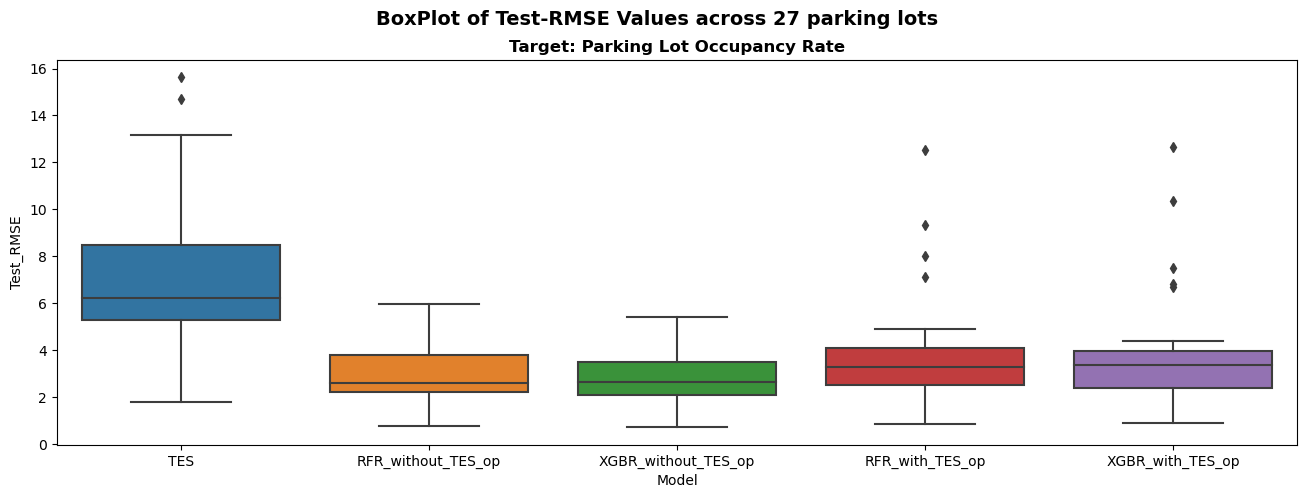

In [91]:
plt.figure(figsize=(16, 5))
sns.boxplot(y=df_rmse_summary_melt['Test_RMSE'], x=df_rmse_summary_melt['Model'])
plt.suptitle('BoxPlot of Test-RMSE Values across 27 parking lots', fontweight='bold', fontsize=14)
plt.title('Target: Parking Lot Occupancy Rate', fontweight='bold', fontsize=12)

# plt.title('BoxPlot of Test-RMSE Values across 27 parking lots', fontsize=12, fontweight='bold')
plt.show()

In [92]:
df_rmse_summary_melt_agg = df_rmse_summary_melt.groupby('Model')['Test_RMSE'].agg(rmse_min='min', rmse_max='max', 
                                                                                  rmse_mean='mean', rmse_std='std', 
                                                                                  rmse_diff_85p_15p=lambda grp: (grp.quantile(0.85)-grp.quantile(0.15)))

new_xorder = ['TES', 'RFR_without_TES_op', 'XGBR_without_TES_op', 'RFR_with_TES_op', 'XGBR_with_TES_op']
df_rmse_summary_melt_agg = df_rmse_summary_melt_agg.reindex(new_xorder)
df_rmse_summary_melt_agg

,rmse_min,rmse_max,rmse_mean,rmse_std,rmse_diff_85p_15p
Model,,,,,
TES,1.808,15.636,7.200333,3.433883,6.2200
RFR_without_TES_op,0.766,5.950,2.928667,1.310276,2.3901
XGBR_without_TES_op,0.729,5.436,2.840741,1.229005,2.5253
RFR_with_TES_op,0.869,12.549,3.846222,2.632804,3.1375
XGBR_with_TES_op,0.908,12.656,3.972296,2.709925,4.7177


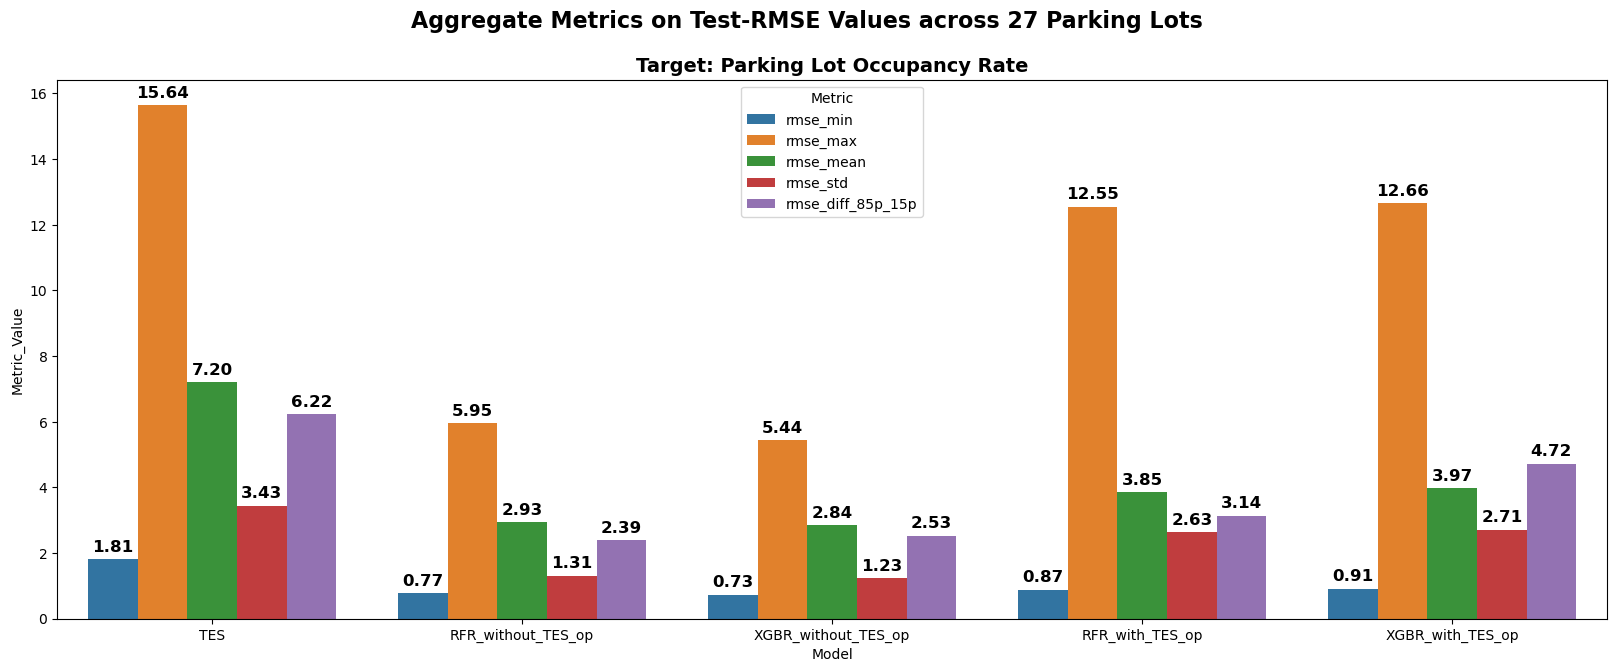

In [93]:
df_rmse_summary_melt_agg_melt2 = df_rmse_summary_melt_agg.reset_index().melt(id_vars='Model', 
                                                                             var_name='Metric', 
                                                                             value_name='Metric_Value')


# Set the size of the figure
plt.figure(figsize=(20, 7))

# Create the barplot
ax = sns.barplot(x='Model', y='Metric_Value', hue='Metric', data=df_rmse_summary_melt_agg_melt2)


for p in ax.patches:
    ax.annotate(format(p.get_height(), '.2f'), 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha = 'center', va = 'center', 
                xytext = (0, 9), 
                textcoords = 'offset points', fontweight='bold',fontsize=12)
    
plt.suptitle('Aggregate Metrics on Test-RMSE Values across 27 Parking Lots', fontweight='bold', fontsize=16)
plt.title('Target: Parking Lot Occupancy Rate', fontweight='bold', fontsize=14)
plt.show()

# Saving the Model with Best Performance

In [99]:
fit_models_best_dict = dict(zip(df_fitted_reg_models_v3['ps_idx'], df_fitted_reg_models_v3['reg_fitted_model']))
fit_std_scaler_dict = dict(zip(df_fitted_reg_models_v3['ps_idx'], df_fitted_reg_models_v3['fitted_scaler']))

# # Saving the fitted models in a dict
# with open('./data_artifacts/fit_models_best_dict.pkl', 'wb') as f:
#     pickle.dump(fit_models_best_dict, f)

# # Saving the fitted models in a dict
# with open('./data_artifacts/fit_std_scaler_dict.pkl', 'wb') as f:
#     pickle.dump(fit_std_scaler_dict, f)